In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset
import os
import matplotlib.pyplot as plt
import random


In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
lamb = 10
lr = .0002
ident_weight = .5
batch_size = 4
img_size = 256
crop_size = 256
num_workers = 4
epochs = 100
log_percent = .10
betas = (.05, .999)
checkpoint_dir = "./Checkpoint/"
x_root = "/media/fico/Data/Kaggle_Monet/Photo"
y_root = "/media/fico/Data/Kaggle_Monet/Monet"


In [3]:
# Many different views on which design is best, using original resnet design
class Residual2d(nn.Module):
    def __init__(self, dim):
        super(Residual2d, self).__init__()
        self.res = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 1, 0),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 1, 0),
            nn.InstanceNorm2d(dim))
        self.relu = nn.ReLU(True)
    
    def forward(self, x):
        output = x + self.res(x)
        output = self.relu(output)
        return output

        

In [4]:
# Generator Code
# Use mirrored padding always or just beginning and final layer
class Generator(nn.Module):
    def __init__(self, rb = 9):
        super(Generator, self).__init__()
#         3x256x256 -> 64x256x256

        self.c7s1_64 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7, 1, 0),
            nn.InstanceNorm2d(64),
            nn.ReLU(True))
    
#         64x256x256 -> 128x128x128
        self.d128 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, 3, 2, 0),
            nn.InstanceNorm2d(128),
            nn.ReLU(True))
        
#         128x128x128 -> 256x64x64
        self.d256 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 256, 3, 2, 0),
            nn.InstanceNorm2d(64),
            nn.ReLU(True))
        
#         256x64x64 -> 256x64x64
        res_blocks = [Residual2d(256) for x in range(rb)]
        self.R9 = nn.Sequential(*res_blocks)
        
#         Try using upsample + conv
#         For some reason padding beforehand doesnt work with convtranpose, 
#         should work even with tranpose special padding rule
#         256x64x64 -> 128x128x128
        self.u128 = nn.Sequential(
#             nn.ReflectionPad2d(1),
            nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1),
#             nn.ReflectionPad2d(1)
        )
        
#         128x128x128 -> 64x256x256
        self.u256 = nn.Sequential(
#             nn.ReflectionPad2d(1),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1),
#             nn.ReflectionPad2d(1)
        )
#         Paper says that its a regulat conv, instance, relu, but it needs tanh
#         for valid clipping, and a tanh cant follow a relu do to relu limiting 0-1.
#         Futhermore, normilization in last layer is not good in most cases
        self.c7s1_3 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7, 1, 0),
#             nn.InstanceNorm2d(64),
#             nn.ReLU(True),
            nn.Tanh())
            
        
    def forward(self, input):
        output = self.c7s1_64(input)
        output = self.d128(output)
        output = self.d256(output)
        output= self.R9(output)
        output= self.u128(output)
        output= self.u256(output)
        output= self.c7s1_3(output)
#         print(output.shape)
        return output


In [5]:
# https://arxiv.org/pdf/1611.07004.pdf
# Try different patch sizes
# Last two convolutions need to have a stride and padding of 1
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.C64 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace= True))
    
        self.C128 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace= True))
        
        self.C256 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace= True))
    
        self.C512 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 1, 1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace= True))
        self.last = nn.Conv2d(512,1, 4, 1, 1)
        
    def forward(self, input):
        output = self.C64(input)
        output = self.C128(output)
        output = self.C256(output)
        output = self.C512(output)
        output = self.last(output)



#         print(output.shape)
        return output


In [6]:
# Change buffering to each image in batch instead of entire batch
class ImageBuffer:
    def __init__(self):
        self.buffer = []
        self.buffer_size = 0    
    def grab(self, batch):
        if self.buffer_size < 50:
            self.buffer.append(batch)
            self.buffer_size += 1
            return batch
        else:
            if random.uniform(0, 1) > 0.5:
                return batch
            else:
                pos = random.randrange(0, self.buffer_size)
                temp = self.buffer[pos]
                self.buffer[pos] = batch
                return temp    

In [7]:
# x: input
# y: target
# G: x -> y
# F: y -> x
class CycleGan:
    def __init__(self):
        self.gen_G = Generator().to(device)
        self.gen_F = Generator().to(device)
        self.dis_x_vs_Fy = Discriminator().to(device)
        self.dis_y_vs_Gx = Discriminator().to(device)
        self.Gx = -1
        self.Fy = -1
        self.G_buffer = ImageBuffer()
        self.F_buffer = ImageBuffer()
        self.lossGx = -1
        self.lossFy= -1
        self.lossY = -1
        self.lossX = -1
        self.crit = nn.MSELoss()
        self.optimizer_gen = torch.optim.Adam(list(self.gen_F.parameters()) + list(self.gen_G.parameters()), lr = lr, betas = betas)
        self.optimizer_dis = torch.optim.Adam(list(self.dis_x_vs_Fy.parameters()) + list(self.dis_y_vs_Gx.parameters()), lr = lr, betas = betas)
        self.scaler_gen = torch.cuda.amp.GradScaler()
        self.scaler_dis = torch.cuda.amp.GradScaler()
        
        self.gen_G.apply(self.init_weights)
        self.gen_F.apply(self.init_weights)
        self.dis_x_vs_Fy.apply(self.init_weights)
        self.dis_y_vs_Gx.apply(self.init_weights)
        
    def init_weights(self, m):
        if type(m) == torch.nn.Conv2d:
#             print(m)
            torch.nn.init.normal_(m.weight, std=0.02, mean = 0.0)
            
    def grad_toggle(self, grad):
        for param in self.dis_x_vs_Fy.parameters():
            param.requires_grad = grad
        for param in self.dis_y_vs_Gx.parameters():
            param.requires_grad = grad
            
    def loss_gen(self, result):
        return self.crit(result, torch.ones_like(result))
    
#     divide by 2 to slow down
    def loss_dis(self, real, fake):
        loss1 = self.crit(real, torch.ones_like(real))
        loss2 = self.crit(fake, torch.zeros_like(fake))
        return (loss1 + loss2) * .5

    def loss_cyclic(self, real, cycled):
        loss = torch.abs(real - cycled)
        return torch.mean(loss) * lamb

    # Found in 5.2 of paper, dont want to have to much weight on looking the same, but dont want artifacts
    def loss_identity(self, real, ident):
        loss = torch.abs(real - ident)
        return torch.mean(loss) * lamb * ident_weight
    
    def generator_loss(self, x, y):
#         input -> target
        self.Gx = self.gen_G(x)
        lossGx = self.loss_gen(self.dis_y_vs_Gx(self.Gx))
        self.lossGx = lossGx.item()
#         cycled
        FGx = self.gen_F(self.Gx)
        lossFGx = self.loss_cyclic(x, FGx)
    
#         target -> input
        self.Fy = self.gen_F(y)
        lossFy = self.loss_gen(self.dis_x_vs_Fy(self.Fy))
        self.lossFy = lossFy.item()

#         cycled
        GFy = self.gen_G(self.Fy)
        lossGFy = self.loss_cyclic(y, GFy)
#         identities
        Fx = self.gen_F(x)
        Gy = self.gen_G(y)

        identGy = self.loss_identity(y, Gy)
        identFx = self.loss_identity(x, Fx)
        

        
        loss = lossGx + lossFy + lossFGx + lossGFy + identGy + identFx
        

        return loss
    
    def discriminator_loss(self, x, y):
        dis_Gx = self.dis_y_vs_Gx(self.G_buffer.grab(self.Gx).detach())
        dis_y = self.dis_y_vs_Gx(y)
        
        dis_Fy = self.dis_x_vs_Fy(self.F_buffer.grab(self.Fy).detach())
        dis_x = self.dis_x_vs_Fy(x)
        
        loss_y = self.loss_dis(dis_y, dis_Gx)
        self.lossY = loss_y.item()
        
        loss_x = self.loss_dis(dis_x, dis_Fy)
        self.lossX = loss_x.item()
        
        loss = loss_x + loss_y
        return loss
    
    def test_photo(self, image, backward = False):
        if not backward:
            with torch.no_grad():
                return self.gen_G(image)
        else:
            with torch.no_grad():
                return self.gen_F(image)
        
        
    def step(self, x, y, step, total_step, log = False):
        self.grad_toggle(False)
        
        self.optimizer_gen.zero_grad()
        with torch.cuda.amp.autocast():
            loss_g = self.generator_loss(x,y)
        self.scaler_gen.scale(loss_g).backward()
        self.scaler_gen.step(self.optimizer_gen)
        self.scaler_gen.update()
        self.grad_toggle(True)

        self.optimizer_dis.zero_grad()
        with torch.cuda.amp.autocast():
            loss_d = self.discriminator_loss(x, y)
        self.scaler_dis.scale(loss_d).backward()
        self.scaler_dis.step(self.optimizer_dis)
        self.scaler_dis.update()
        if log:
            print("Step:", str(step) + "/" + str(total_step), "loss Gx: ", self.lossGx, "loss Fy: ", self.lossFy, "loss disY: ", self.lossY, "loss disX: ", self.lossX)
    
    
    
    def checkpoint(self, epoch):
        path = checkpoint_dir + "current_check"
        torch.save({
            'gen_G': self.gen_G.state_dict(),
            'gen_F': self.gen_F.state_dict(),
            'dis_x_vs_Fy': self.dis_x_vs_Fy.state_dict(),
            'dis_y_vs_Gx': self.dis_y_vs_Gx.state_dict(),
            'optimizer_gen': self.optimizer_gen.state_dict(),
            'optimizer_dis': self.optimizer_dis.state_dict(),
            'scaler_gen': self.scaler_gen.state_dict(),
            'scaler_dis': self.scaler_dis.state_dict(),
            'epoch': epoch,
            }, path)

            


In [8]:
# Work on creating a dataset where randomCrop is randombly called so that full images are pushed in, requires doing the same action on images
class DataLoader:
    def __init__(self, im_s, cro_s):
        self.data_set_x = self.load_data(x_root, im_s, cro_s)
        self.size_x = len(self.data_set_x)
        self.x_iter = iter(self.data_set_x)
        
        self.data_set_y = self.load_data(y_root, im_s, cro_s)
        self.size_y = len(self.data_set_y)
        self.y_iter = iter(self.data_set_y)
    
    def load_data(self, dataroot, im_s, cro_s):
        dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(im_s),
                               transforms.RandomCrop(cro_s),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
        data_load = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers, drop_last=True)
        return data_load
    
    def next_pair(self):
        try:
            img_x = self.x_iter.next()

        except StopIteration:
            self.x_iter = iter(self.data_set_x)
            img_x = self.x_iter.next()
        
        try:
            img_y = self.y_iter.next()

        except StopIteration:
            self.y_iter = iter(self.data_set_y)
            img_y = self.y_iter.next()
        return img_x[0].to(device), img_y[0].to(device)
    
    def update_dictionary(self, im_s, cro_s):
        self.data_set_x = self.load_data(x_root, im_s, cro_s)
        self.size_x = len(self.data_set_x)
        self.x_iter = iter(self.data_set_x)
        
        self.data_set_y = self.load_data(y_root, im_s, cro_s)
        self.size_y = len(self.data_set_y)
        self.y_iter = iter(self.data_set_y)
            

In [9]:
def image_log(real, output):
    old_min = -1
    old_max = 1
    old_range = old_max - old_min
    new_range = 1 - 0
    real = (((real - old_min)*new_range)/ old_range) + 0
    output = (((output - old_min)*new_range)/ old_range) + 0
    real = real.permute(0,2,3,1)
    output = output.permute(0,2,3,1)
    fig= plt.figure(figsize=(10,50))
    col = 2
    row = 1
    count = 0
    for i in range(1, col * row + 1, 2):
        if 1%2 ==1:
            img = real[count, :, :]
            fig.add_subplot(row, col, i)
            plt.imshow(img)
            plt.axis('off')
            
            img = output[count, :, :]
            fig.add_subplot(row, col, i + 1)
            plt.imshow(img) 
            plt.axis('off')
            count += 1
    plt.show()

In [10]:
def check_directories():
    if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

In [11]:
def adjust_lr(optimizer, epoch):
    lr = init_lr * (0.1 ** (epoch // epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [12]:
check_directories()
images = DataLoader(286,256)
gan = CycleGan()
progress_x, progress_y = images.next_pair()


Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
Conv2d(256, 256,

Starting Training
Starting Epoch: 0
Step: 0/75 loss Gx:  3.547407388687134 loss Fy:  1.492376446723938 loss disY:  3.184497356414795 loss disX:  1.4585330486297607


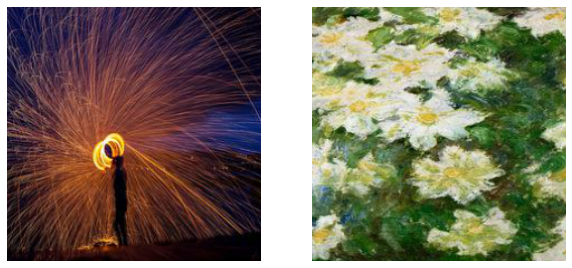

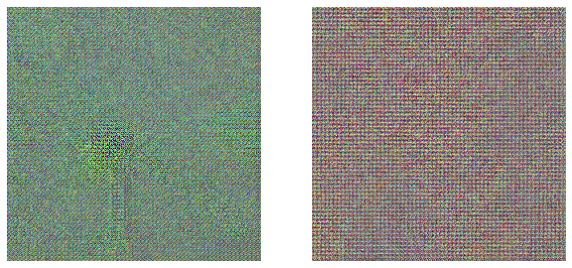

KeyboardInterrupt: 

In [13]:
print("Starting Training")
log_count = int(images.size_y * log_percent)
for epoch in range(epochs):
    print("Starting Epoch: "  + str(epoch))
    for t in range(images.size_y):
        x, y = images.next_pair()
        if t %log_count == 0:
            gan.step(x, y, t, images.size_y, log = True)
            image_log(x.cpu(), y.cpu())
            temp_x = gan.test_photo(x)
            temp_y = gan.test_photo(y, backward = True)
            image_log(temp_x.cpu(), temp_y.cpu())
            plt.close('all')
        else:
            gan.step(x, y,  t, images.size_y, )
    gan.checkpoint(epoch)
        
        
        


In [ ]:
# images = DataLoader(256,256)
# for t in range(10):
#     x, y = images.next_pair()

#     temp_x = gan.test_photo(x)
#     temp_y = gan.test_photo(y, backward = True)
#     image_log(temp_x.cpu(), temp_y.cpu())
#     plt.close('all')
